# Example code to load, analyze and export the data

In [2]:
from pathlib import Path
import datetime
import numpy as np
import scipy.signal as spsig 
from scipy.io import wavfile
import h5py
import pyproj
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
import matplotlib.dates as mdates
UTC = datetime.timezone.utc

In [3]:
DataDir = Path("C:/Users/jrych/OneDrive - ETH Zurich/OrcaData/2023-01 Orcalize/PublishData")
ExcursionsFile = DataDir / 'Excursions.hdf5'

In [4]:
# define the geopgaohic projection and bounding box

with h5py.File(ExcursionsFile, "r") as f:
    lat_0 = f.attrs['Local Coordinate System Origin Latitude']
    lon_0 = f.attrs['Local Coordinate System Origin Longitude']
    proj4_str = f.attrs['Local Coordinate System Proj4 String'] 
    
CRS_Skjervoy = ccrs.Stereographic(central_latitude=lat_0, central_longitude=lon_0)
ProjSkjervoy = pyproj.Proj(proj4_str) 

xl =  - 10000
xm =  + 30000
yl =  - 20000
ym =  + 15000

(lon_m, lat_m) = ProjSkjervoy(xm, ym, inverse=True)
(lon_l, lat_l) = ProjSkjervoy(xl, yl, inverse=True)

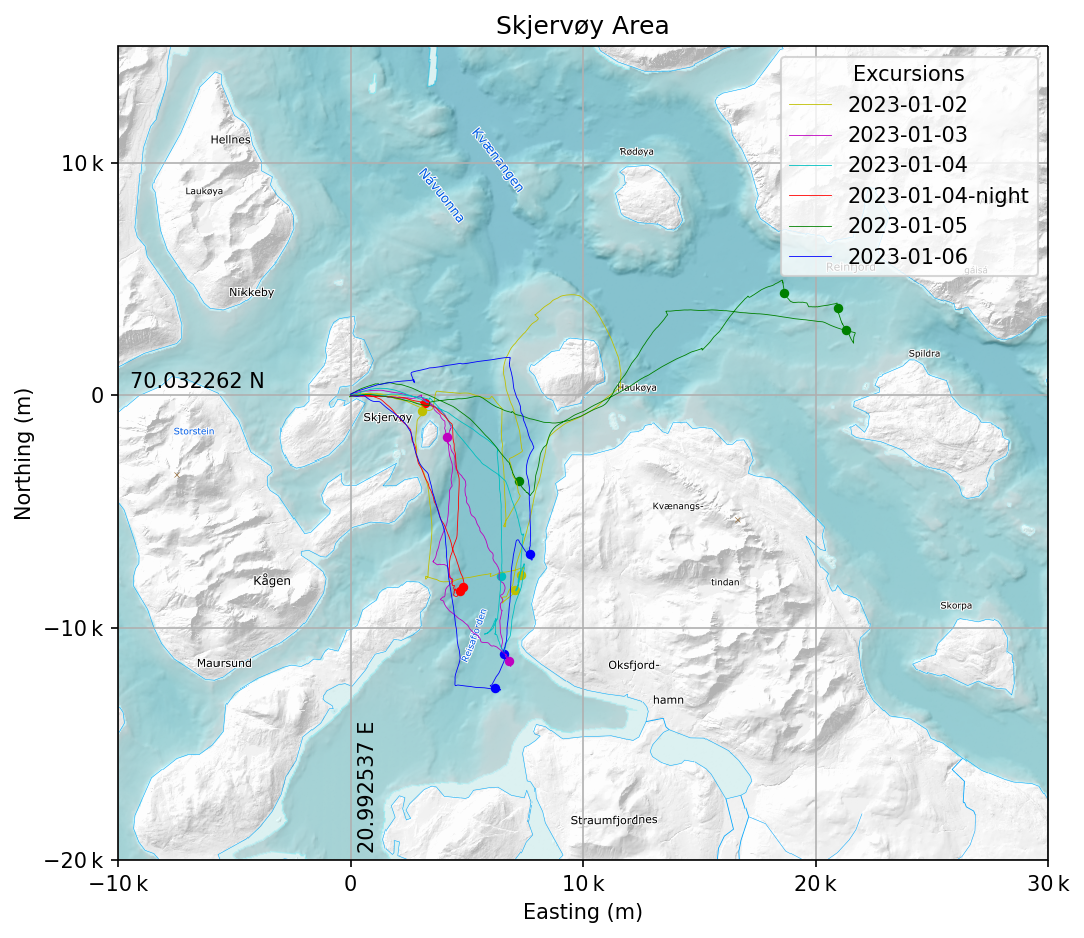

In [5]:
# plot an overview of all excursions and all recording sites

fig = plt.figure(figsize=(8,8), dpi=150)
ax = fig.subplots(1,1, subplot_kw={'projection':CRS_Skjervoy})
extent = (xl, xm, yl, ym)
ax.set_extent(extent, crs=CRS_Skjervoy)

# add the maps from Norwegian web map services
ax.add_wms(wms='https://wms.geonorge.no/skwms1/wms.topo4', layers='Vannflate')
ax.add_wms(wms='https://wms.geonorge.no/skwms1/wms.havbunnraster3', layers='farget_havbunnraster_dybde_skygge')
# ax.add_wms(wms='https://wms.geonorge.no/skwms1/wms.dybdedata2', layers=['Dybdelag','Dybdekontur'])
# ax.add_wms(wms='https://wms.geonorge.no/skwms1/wms.terrengmodell', layers='relieff')
# map with streets etc. can add 'Veger','Ferger' , 'Arealdekkeflate', 'Hoydekurver'
ax.add_wms(wms='https://wms.geonorge.no/skwms1/wms.topo4', layers=['fjellskygge', 'vannkontur','elver','Stedsnavn','Hoydepunkt'])

# plot all excursions
with h5py.File(ExcursionsFile, "r") as f:
    clrs = dict(zip(f.keys(),('y','m','c','r','g','b')))
    for excursion, trk in f.items(): 
        ax.plot(f[excursion][:,0], f[excursion][:,1], label=excursion, color=clrs[excursion], linewidth=0.4, transform=CRS_Skjervoy )

# plot all recording locations        
for rec_file in list(DataDir.glob("2023*.hdf5")): 
    with h5py.File(rec_file, "r") as f:
        mpos = f['Track'].attrs['Mean Position']
        excursion = f['Track'].attrs['Excursion']
        ax.scatter(mpos[0], mpos[1], color=clrs[excursion], marker=".", s=50)
        
ax.legend(title='Excursions') 
ax.set_xticks([extent[0],extent[1]])
ax.set_yticks([extent[2],extent[3]]) 
    
ax.xaxis.set_major_locator(tik.MultipleLocator(10000))
ax.yaxis.set_major_locator(tik.MultipleLocator(10000))
ax.xaxis.set_major_formatter(tik.EngFormatter(places=0, sep="\N{THIN SPACE}"))
ax.yaxis.set_major_formatter(tik.EngFormatter(places=0, sep="\N{THIN SPACE}"))
ax.grid(True)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.text(extent[0]+500, 300,'{0:.6f} N'.format(lat_0))
ax.text(+300, extent[2]+500,'{0:.6f} E'.format(lon_0), fontdict={'rotation':'vertical'})

ax.set_title('Skjervøy Area');

## Export into wav files for RavenPro
WAV files for anaysis with RavenPro software. Only on channel (Tetra-Top) is used. The full sampling rate (192 KHz) and the floating point format is maintained which allows for quantitative measurements in Raven (signal is in kPa).  

In [5]:
chunk_dur = datetime.timedelta(minutes=90) # the maximum time of files  
chan = 'Tetra-Top'
RefLevel = 1000 # in Pa. 
# The wav files will be +- 1 kPa because Raven clipps values >1. 
# make sure to use the correct calibration when loading into Raven
WavDir = DataDir / 'Raven' 
try:
    WavDir.mkdir()
except:
    None

In [19]:
for rec_file in list(DataDir.glob("2023*.hdf5")): 
    with h5py.File(rec_file, "r") as f:
        file_channels = list(f['Signals'].attrs['Channels'])
        i = file_channels.index(chan)
        data = f['Signals'][:,i]
        start_t = f['Signals'].attrs['Start Time']
        start_t = datetime.datetime.strptime(start_t.decode('ascii'),'%Y-%m-%dT%H:%M:%S.%f%z')
        count = int(f['Signals'].attrs['Samples'])
        sr = f['Signals'].attrs['Sample Rate (Hz)']
        chunk_count = int(sr * chunk_dur.total_seconds())
        count_start = int(0)
        while count > 0:
            dur_count = min(count, chunk_count)
            dur = datetime.timedelta(seconds=dur_count/sr)
            write_filename = start_t.strftime('%Y-%m-%d--%H-%M-%S')
            write_filename += '--'
            write_filename += datetime.datetime.utcfromtimestamp(dur.total_seconds()).strftime('%H-%M-%S') # no nice way to format timedelta?
            write_filename += '.wav'
            d = data[count_start:count_start+dur_count] / RefLevel # Ravan does not like values >1. store in MPa
            print(max(d), min(d))
            wavfile.write(WavDir / write_filename, int(sr), d)
            count_start += dur_count
            count -= dur_count
            start_t += dur

0.13109763 -0.2034773
0.16217305 -0.16224302
0.008056017 -0.008523863
0.008094295 -0.007500476
0.052910097 -0.04819822
0.0066809324 -0.006676215
0.03585092 -0.059120476
0.12140803 -0.17421776
0.21351247 -0.41963443
0.01653905 -0.016333738
0.011911618 -0.011167083
0.0057486407 -0.009118377
0.05115981 -0.028974269
0.1159597 -0.2044613
0.00674156 -0.0069365865
0.010433839 -0.012757455


## Export to stereo audio wav files for listening

Wav files for human listening. Two horizontal hydrophones with ca. 70 cm distance provide a stereo perception. The data is downsampled to 48 kHz and reduced in dynamic range with 16 bit (5 Pa as maximum level). 

In [97]:
chunk_dur = datetime.timedelta(minutes=80) 
chanL = 'Tetra-A'
chanR = 'Tetra-B'
RefLevel = 5 # in Pascal 
WavDir = DataDir / 'WAV'  
try:
    WavDir.mkdir(parents=True)
except:
    None

In [98]:
for rec_file in list(DataDir.glob("2023*.hdf5")): 
    with h5py.File(rec_file, "r") as f:
        file_channels = list(f['Signals'].attrs['Channels'])
        il = file_channels.index(chanR)
        ir = file_channels.index(chanL)
        datal = f['Signals'][:,il] / RefLevel * np.iinfo(np.int16).max
        datar = f['Signals'][:,ir] / RefLevel * np.iinfo(np.int16).max
        sr = f['Signals'].attrs['Sample Rate (Hz)']
    
        # downsample and convert to 16 bit 
        q = int(sr / 48000) # decimation ratio
        datal = np.clip(spsig.decimate(datal, q),np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype('int16')
        datar = np.clip(spsig.decimate(datar, q),np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype('int16')
        sr = int(sr/q)
        data = np.column_stack((datar, datal))
        
        start_t = f['Signals'].attrs['Start Time']
        start_t = datetime.datetime.strptime(start_t.decode('ascii'),'%Y-%m-%dT%H:%M:%S.%f%z')
 
        count = len(data)
        chunk_count = int(sr * chunk_dur.total_seconds())
        count_start = int(0)
        
        while count > 0:
            dur_count = min(count, chunk_count)
            dur = datetime.timedelta(seconds=dur_count/sr)
            write_filename = start_t.strftime('%Y-%m-%d--%H-%M-%S')
            write_filename += '--'
            write_filename += datetime.datetime.utcfromtimestamp(dur.total_seconds()).strftime('%H-%M-%S') # no nice way to format timedelta?
            write_filename += '.wav'
            wavfile.write(WavDir / write_filename, int(sr), data[count_start:count_start+dur_count,:])
            count_start += dur_count
            count -= dur_count
            start_t += dur

## Get a section

In [6]:
def GetSectionFromHDF5(filepath, timestamp, duration):
    ''' 
    filepath: path-object or string
    timestamp: datetime.datetime: beginnig of section
    duration: datetime.timedelta
    return: wav[channel], pos[station]
    wav: array with samplings in units of Pascal
    sr: samplerate of wav
    pos: x,y mean position in local coordinate system 
    '''

    with h5py.File(filepath, "r") as f:
        sr = f['Signals'].attrs['Sample Rate (Hz)']
        st = f['Signals'].attrs['Start Time']
        st = datetime.datetime.strptime(st.decode('ascii'),'%Y-%m-%dT%H:%M:%S.%f%z')
        
        nst = np.datetime64(st.astimezone(UTC).replace(tzinfo=None),'ns') 
        nts = np.datetime64(timestamp.astimezone(UTC).replace(tzinfo=None),'ns')
        
        t_ns = np.arange(0, duration.total_seconds(), 1/sr) * 10**9   
        time = t_ns.astype('timedelta64[ns]')
        time = nts + time 
        
        i0 = int((timestamp-st).total_seconds()*sr) 
        i1 = int((timestamp+duration-st).total_seconds()*sr) 
        
        wav={}
        for i,ch in enumerate(f['Signals'].attrs['Channels']): 
            wav[ch] = f['Signals'][i0:i1,i]
            
        tr = f['Track'].attrs['Sample Rate (Hz)']
        i0 = int((timestamp-st).total_seconds()*tr)
        i1 = int((timestamp+duration-st).total_seconds()*tr) 
        pos = [f['Track'][i0:i1,0].mean(), f['Track'][i0:i1,1].mean()]
    return wav, time, sr, pos

## Some highlights 

### Killer whale clicks

In [95]:
file = list(DataDir.glob("2023*.hdf5"))[0]
timestamp = datetime.datetime(2023, 1, 2, 11, 11, 51, 500000, tzinfo=UTC)
duration = datetime.timedelta(seconds=5.5)
wav, time, sr, pos = GetSectionFromHDF5(file, timestamp, duration)

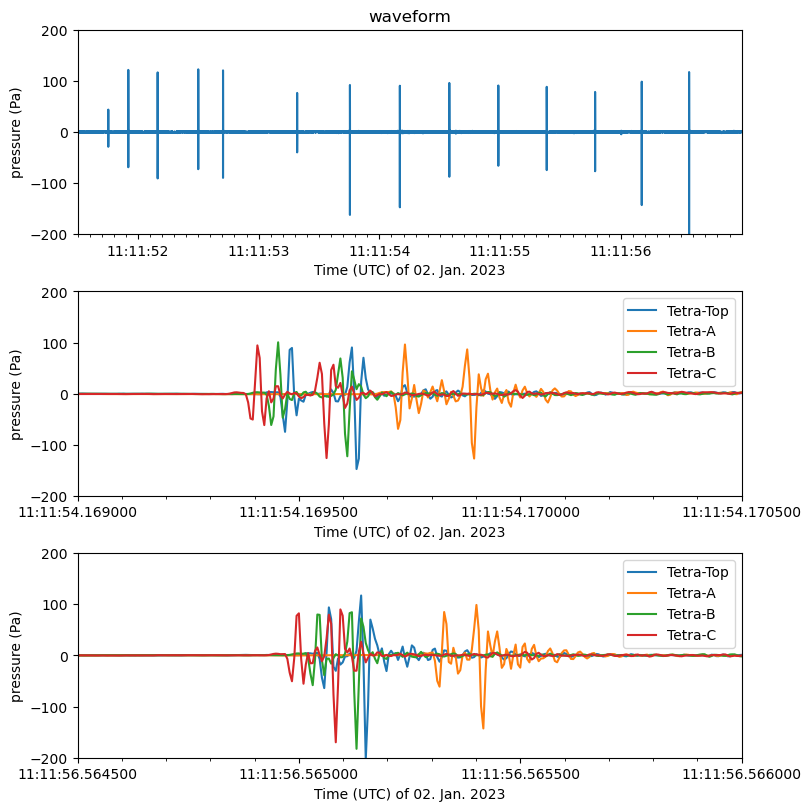

In [103]:
fig = plt.figure(figsize=(8,8), layout='constrained')
ax1, ax2, ax3 = fig.subplots(3,1)

ax1.plot(time,wav['Tetra-Top'])
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('pressure (Pa)')
ax1.set_ylim([-200,200])
t0_datestring = timestamp.strftime('%d. %b. %Y')
ax1.set_xlabel('Time (UTC) of '+ t0_datestring)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S')) 
ax1.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.MicrosecondLocator(interval=100000))
ax1.set_title('waveform');

for ch in ['Tetra-Top','Tetra-A','Tetra-B','Tetra-C']:
    ax2.plot(time, wav[ch], label=ch)
t1 = np.datetime64('2023-01-02T11:11:54.1690','ns')
t2 = np.datetime64('2023-01-02T11:11:54.1705','ns')
ax2.set_xlim([t1, t2])
ax2.set_ylabel('pressure (Pa)')
ax2.set_ylim([-200,200])
ax2.set_xlabel('Time (UTC) of '+ t0_datestring)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f')) 
ax2.xaxis.set_major_locator(mdates.MicrosecondLocator(interval=500))
ax2.xaxis.set_minor_locator(mdates.MicrosecondLocator(interval=100))
ax2.legend()

for ch in ['Tetra-Top','Tetra-A','Tetra-B','Tetra-C']:
    ax3.plot(time,wav[ch], label=ch)
t1 = np.datetime64('2023-01-02T11:11:56.5645','ns')
t2 = np.datetime64('2023-01-02T11:11:56.566','ns')
ax3.set_xlim([t1, t2])
ax3.set_ylabel('pressure (Pa)')
ax3.set_ylim([-200,200])
ax3.set_xlabel('Time (UTC) of '+ t0_datestring)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f')) 
ax3.xaxis.set_major_locator(mdates.MicrosecondLocator(interval=500))
ax3.xaxis.set_minor_locator(mdates.MicrosecondLocator(interval=100))
ax3.legend();

## Humpback whale songs

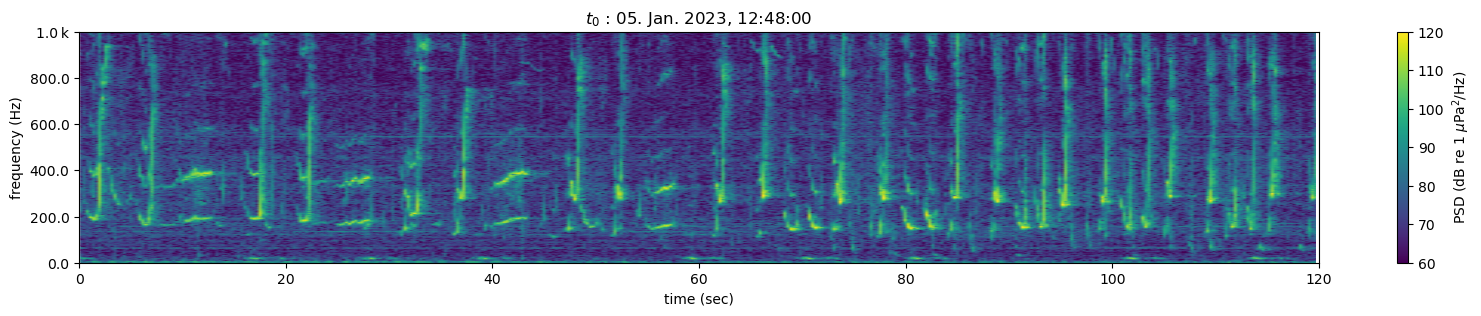

In [234]:
file = DataDir / '2023-01-05--12-26-21--01-01-32.hdf5' 
t_start = datetime.datetime(2023, 1, 5,12, 48, 0, tzinfo=UTC)
t_end   = datetime.datetime(2023, 1, 5,12, 50, 0, tzinfo=UTC)
duration = t_end - t_start
wav, time, sr, pos = GetSectionFromHDF5(file, t_start, duration) 

fig = plt.figure(figsize=(20,3))
ax = fig.subplots()

data = wav['Tetra-Top']
data = spsig.resample(data, int(len(data)/64)) 

(f, t, spectr) = spsig.spectrogram(data, sr/q, nperseg=2**10, window=('gaussian',2**8), scaling='density')    
pcm = ax.pcolormesh(t, f, 10*np.log10(spectr) + 120,   # uPa as reference level 
                    shading='gouraud', cmap='viridis',vmin=60, vmax=120)
ax.set_xlim([0,120])
ax.set_ylim([0,1000])
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('time (sec)')
ax.yaxis.set_major_formatter(tik.EngFormatter(places=1, sep="\N{THIN SPACE}"))
ax.set_title('$t_0$ : ' + t_start.strftime('%d. %b. %Y, %H:%M:%S'))
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('PSD (dB re 1 $\mu$Pa$^2$/Hz)');

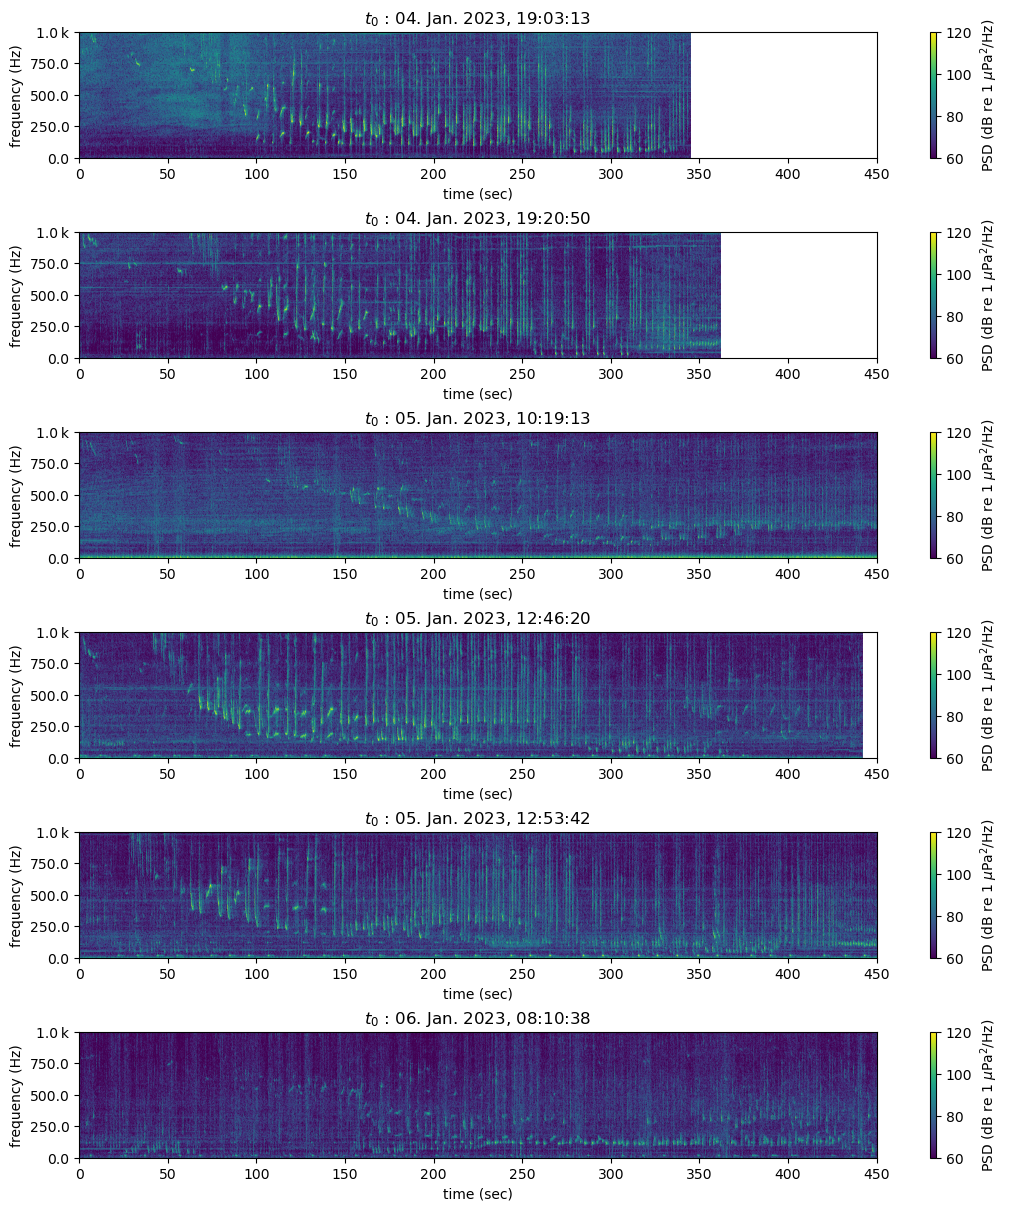

In [242]:
# for the documentation, only a subselection is shown.
sections = [    
    #('2023-01-04--11-26-33--00-19-19', datetime.datetime(2023, 1, 4,11,36,50, tzinfo=UTC), datetime.datetime(2023, 1, 4,11,44,33, tzinfo=UTC)),
    ('2023-01-04--18-32-15--01-10-44', datetime.datetime(2023, 1, 4,19, 3,13, tzinfo=UTC), datetime.datetime(2023, 1, 4,19, 8,58, tzinfo=UTC)),
    ('2023-01-04--18-32-15--01-10-44', datetime.datetime(2023, 1, 4,19,20,50, tzinfo=UTC), datetime.datetime(2023, 1, 4,19,26,52, tzinfo=UTC)),
    # ('2023-01-05--09-44-38--00-52-49', datetime.datetime(2023, 1, 5, 9,47,17, tzinfo=UTC), datetime.datetime(2023, 1, 5, 9,57, 1, tzinfo=UTC)),
    # ('2023-01-05--09-44-38--00-52-49', datetime.datetime(2023, 1, 5, 9,57, 1, tzinfo=UTC), datetime.datetime(2023, 1, 5,10, 8,34, tzinfo=UTC)),
    # ('2023-01-05--09-44-38--00-52-49', datetime.datetime(2023, 1, 5,10, 8,34, tzinfo=UTC), datetime.datetime(2023, 1, 5,10,19,13, tzinfo=UTC)),
    ('2023-01-05--09-44-38--00-52-49', datetime.datetime(2023, 1, 5,10,19,13, tzinfo=UTC), datetime.datetime(2023, 1, 5,10,30,56, tzinfo=UTC)),
    ('2023-01-05--12-26-21--01-01-32', datetime.datetime(2023, 1, 5,12,46,20, tzinfo=UTC), datetime.datetime(2023, 1, 5,12,53,42, tzinfo=UTC)),
    ('2023-01-05--12-26-21--01-01-32', datetime.datetime(2023, 1, 5,12,53,42, tzinfo=UTC), datetime.datetime(2023, 1, 5,13, 1,15, tzinfo=UTC)),
    # ('2023-01-05--12-26-21--01-01-32', datetime.datetime(2023, 1, 5,13, 1,15, tzinfo=UTC), datetime.datetime(2023, 1, 5,13, 7,56, tzinfo=UTC)),
    ('2023-01-06--08-07-48--00-30-11', datetime.datetime(2023, 1, 6, 8,10,38, tzinfo=UTC), datetime.datetime(2023, 1, 6, 8,20, 6, tzinfo=UTC)),
    # ('2023-01-06--09-16-18--00-27-41', datetime.datetime(2023, 1, 6, 9,24,55, tzinfo=UTC), datetime.datetime(2023, 1, 6, 9,35,17, tzinfo=UTC))
    ]
N_sec = len(sections)
fig = plt.figure(figsize=(10,2*N_sec), layout='constrained')
axs = fig.subplots(N_sec,1)
for i in range(N_sec): 
    section = sections[i]
    ax = axs[i]
    wav, time, sr, pos = GetSectionFromHDF5(DataDir/(section[0]+'.hdf5'), section[1], section[2]-section[1])
    wav = spsig.resample(wav['Tetra-Top'], int(len(wav['Tetra-Top'])/64)) 
    (f, t, spectr) = spsig.spectrogram(wav, sr/64, nperseg=2**9, window=('gaussian',2**7), scaling='density')
    
    pcm = ax.pcolormesh(t, f, 10*np.log10(spectr) + 120,   # uPa as reference level 
                    shading='gouraud', cmap='viridis',vmin=60, vmax=120)
    ax.set_xlim([0,450]) # or [0 700] 
    ax.set_ylim([0,1000])
    ax.set_ylabel('frequency (Hz)')
    ax.set_xlabel('time (sec)')
    ax.yaxis.set_major_formatter(tik.EngFormatter(places=1, sep="\N{THIN SPACE}"))
    ax.set_title('$t_0$ : ' + section[1].strftime('%d. %b. %Y, %H:%M:%S'))
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('PSD (dB re 1 $\mu$Pa$^2$/Hz)');        

## Orca calls

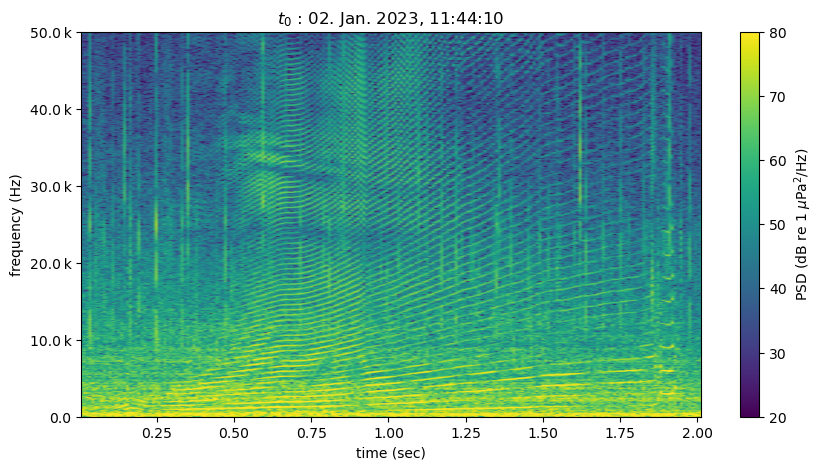

In [12]:
file = DataDir / '2023-01-02--11-27-50--00-37-57.hdf5' 
t_start = datetime.datetime(2023, 1, 2,11,44,10,411000, tzinfo=UTC)
t_end   = datetime.datetime(2023, 1, 2,11,44,12,434000, tzinfo=UTC)
duration = t_end - t_start
wav, time, sr, pos = GetSectionFromHDF5(file, t_start, duration) 

fig = plt.figure(figsize=(10,5))
ax = fig.subplots()

data = wav['Tetra-Top']

(f, t, spectr) = spsig.spectrogram(data, sr, nperseg=2**11, window=('gaussian',2**9), scaling='density')    
pcm = ax.pcolormesh(t, f, 10*np.log10(spectr) + 120,   # uPa as reference level 
                    shading='gouraud', cmap='viridis',vmin=20, vmax=80)
# ax.set_xlim([0,60])
ax.set_ylim([0,50000])
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('time (sec)')
ax.yaxis.set_major_formatter(tik.EngFormatter(places=1, sep="\N{THIN SPACE}"))
ax.set_title('$t_0$ : ' + t_start.strftime('%d. %b. %Y, %H:%M:%S'))
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('PSD (dB re 1 $\mu$Pa$^2$/Hz)');

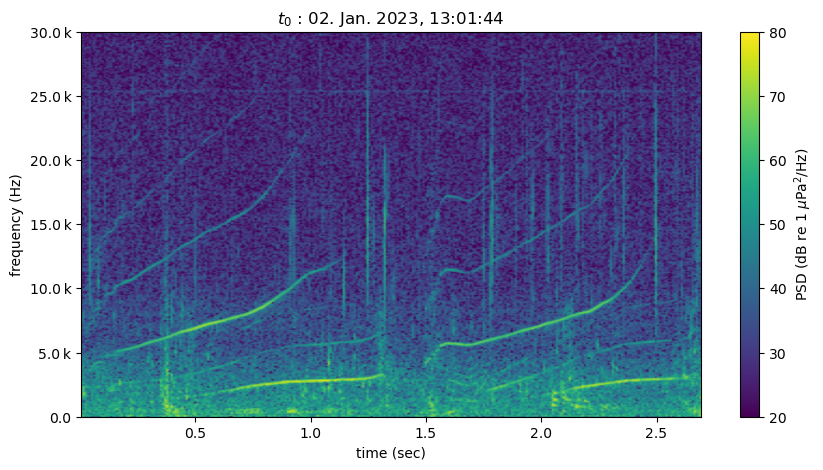

In [14]:
file = DataDir / '2023-01-02--12-56-55--00-09-08.hdf5' 
t_start = datetime.datetime(2023, 1, 2,13, 1,44,     0, tzinfo=UTC)
t_end   = datetime.datetime(2023, 1, 2,13, 1,46,700000, tzinfo=UTC)
duration = t_end - t_start
wav, time, sr, pos = GetSectionFromHDF5(file, t_start, duration) 

fig = plt.figure(figsize=(10,5))
ax = fig.subplots()

data = wav['Tetra-Top']

(f, t, spectr) = spsig.spectrogram(data, sr, nperseg=2**11, window=('gaussian',2**9), scaling='density')    
pcm = ax.pcolormesh(t, f, 10*np.log10(spectr) + 120,   # uPa as reference level 
                    shading='gouraud', cmap='viridis',vmin=20, vmax=80)
# ax.set_xlim([0,60])
ax.set_ylim([0,30000])
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('time (sec)')
ax.yaxis.set_major_formatter(tik.EngFormatter(places=1, sep="\N{THIN SPACE}"))
ax.set_title('$t_0$ : ' + t_start.strftime('%d. %b. %Y, %H:%M:%S'))
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('PSD (dB re 1 $\mu$Pa$^2$/Hz)');

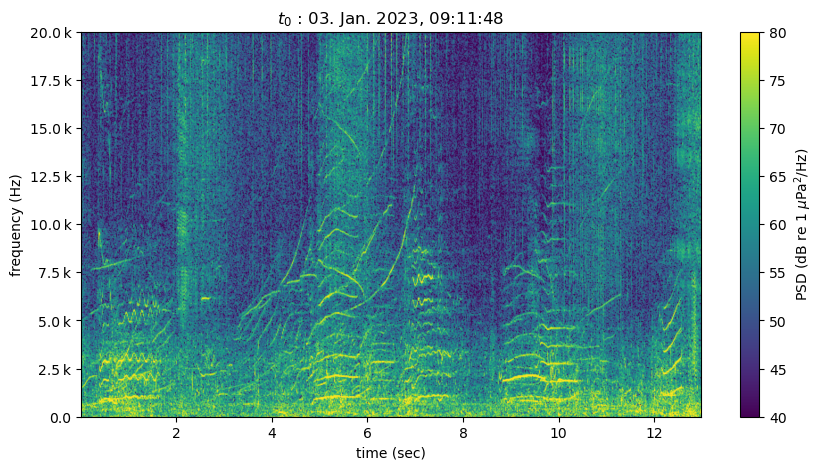

In [20]:
file = DataDir / '2023-01-03--09-01-52--00-25-45.hdf5' 
t_start = datetime.datetime(2023, 1, 3, 9,11,48,     0, tzinfo=UTC)
t_end   = datetime.datetime(2023, 1, 3, 9,12, 1,     0, tzinfo=UTC)
duration = t_end - t_start
wav, time, sr, pos = GetSectionFromHDF5(file, t_start, duration) 

fig = plt.figure(figsize=(10,5))
ax = fig.subplots()

data = wav['Tetra-Top']

(f, t, spectr) = spsig.spectrogram(data, sr, nperseg=2**12, window=('gaussian',2**10), scaling='density')    
pcm = ax.pcolormesh(t, f, 10*np.log10(spectr) + 120,   # uPa as reference level 
                    shading='gouraud', cmap='viridis',vmin=40, vmax=80)
# ax.set_xlim([0,60])
ax.set_ylim([0,20000])
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('time (sec)')
ax.yaxis.set_major_formatter(tik.EngFormatter(places=1, sep="\N{THIN SPACE}"))
ax.set_title('$t_0$ : ' + t_start.strftime('%d. %b. %Y, %H:%M:%S'))
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('PSD (dB re 1 $\mu$Pa$^2$/Hz)');

## Sonar and an unknown underwater acoustic device 

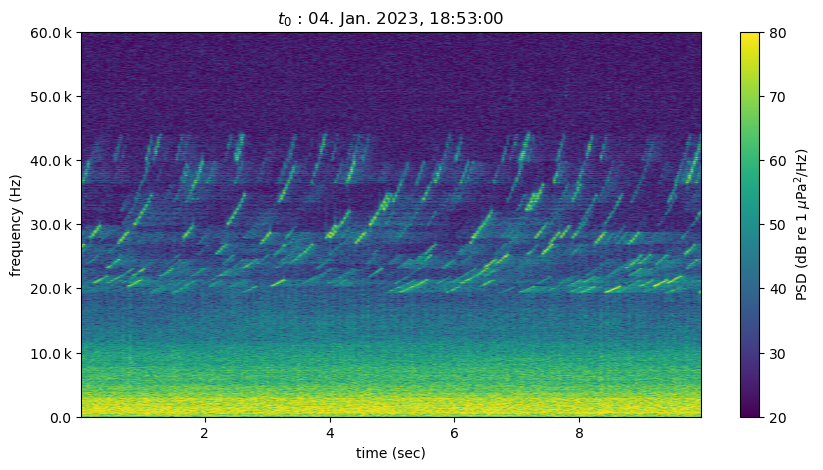

In [7]:
file = DataDir / '2023-01-04--18-32-15--01-10-44.hdf5' 
t_start = datetime.datetime(2023, 1, 4,18,53, 0, tzinfo=UTC)
t_end   = datetime.datetime(2023, 1, 4,18,53,10, tzinfo=UTC)
duration = t_end - t_start
wav, time, sr, pos = GetSectionFromHDF5(file, t_start, duration) 

fig = plt.figure(figsize=(10,5))
ax = fig.subplots()

data = wav['Tetra-Top']

(f, t, spectr) = spsig.spectrogram(data, sr, nperseg=2**13, window=('gaussian',2**11), scaling='density')    
pcm = ax.pcolormesh(t, f, 10*np.log10(spectr) + 120,   # uPa as reference level 
                    shading='gouraud', cmap='viridis',vmin=20, vmax=80)
# ax.set_xlim([0,60])
ax.set_ylim([0,60000])
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('time (sec)')
ax.yaxis.set_major_formatter(tik.EngFormatter(places=1, sep="\N{THIN SPACE}"))
ax.set_title('$t_0$ : ' + t_start.strftime('%d. %b. %Y, %H:%M:%S'))
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('PSD (dB re 1 $\mu$Pa$^2$/Hz)');

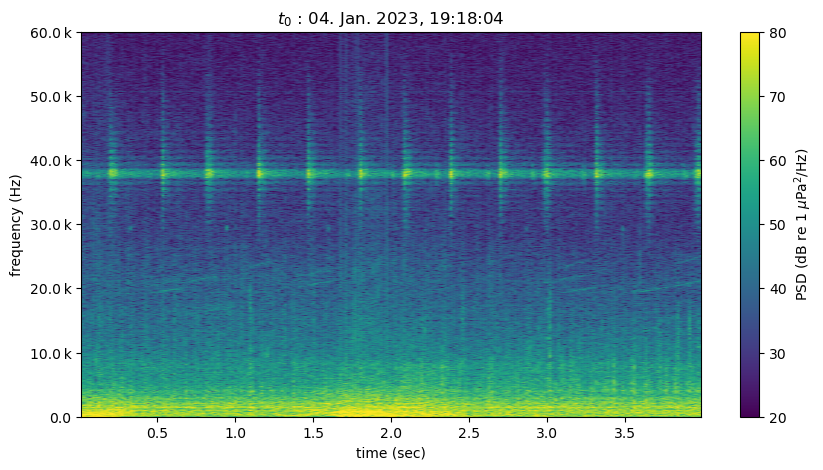

In [22]:
file = DataDir / '2023-01-04--18-32-15--01-10-44.hdf5' 
t_start = datetime.datetime(2023, 1, 4,19,18, 4, tzinfo=UTC)
t_end   = datetime.datetime(2023, 1, 4,19,18, 8, tzinfo=UTC)
duration = t_end - t_start
wav, time, sr, pos = GetSectionFromHDF5(file, t_start, duration) 

fig = plt.figure(figsize=(10,5))
ax = fig.subplots()

data = wav['Tetra-Top']

(f, t, spectr) = spsig.spectrogram(data, sr, nperseg=2**12, window=('gaussian',2**11), scaling='density')    
pcm = ax.pcolormesh(t, f, 10*np.log10(spectr) + 120,   # uPa as reference level 
                    shading='gouraud', cmap='viridis',vmin=20, vmax=80)
# ax.set_xlim([0,60])
ax.set_ylim([0,60000])
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('time (sec)')
ax.yaxis.set_major_formatter(tik.EngFormatter(places=1, sep="\N{THIN SPACE}"))
ax.set_title('$t_0$ : ' + t_start.strftime('%d. %b. %Y, %H:%M:%S'))
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('PSD (dB re 1 $\mu$Pa$^2$/Hz)');